In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import os 
DATA_DIR = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution"


demo_dirs = os.listdir(DATA_DIR)
# filter out directories that are not demos
demo_dirs = [d for d in demo_dirs if os.path.isdir(os.path.join(DATA_DIR, d))]
# sort by name
demo_dirs.sort()
print(f"Found {len(demo_dirs)} demonstrations")


# ðemo dir 
#  back_camera
# data.mp4

video_paths = [os.path.join(DATA_DIR, demo_dir, "back_camera", "data.mp4") for demo_dir in demo_dirs]
print(video_paths)

Found 31 demonstrations
['/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_0/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_1/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_10/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_11/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_12/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_13/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_14/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_15/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullre

In [3]:
# get initial frames for each video

initial_frames = []
for video_path in video_paths:
    video = cv2.VideoCapture(video_path)
    ret, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    initial_frames.append(frame)

# save the initial frames
initial_frames = np.array(initial_frames)

In [4]:
# # instead, now get all frames of a single video
url = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_1/back_camera/data.mp4"

import imageio.v3 as iio
frames = iio.imread(url, plugin="FFMPEG")  # plugin="pyav"
# frames = frames[-1100:-800]
print(len(frames))
initial_frames = frames[::40]
print(len(initial_frames))

855
22


In [5]:
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor
model_id =  "IDEA-Research/grounding-dino-tiny"
model_id =  "IDEA-Research/grounding-dino-base"
# model_id = "google/owlv2-base-patch16"
device = "cuda"
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)









Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import torch


# will only compile on first call
# img = np.random.randint(0, 255, (100, 100, 3))
# text_labels = ["dummy"]
# inputs = processor(text=text_labels, images=img, return_tensors="pt").to(device)


# model.compile()


# with torch.no_grad():
#     outputs = model(**inputs)


In [7]:
text_labels = ["pen", "box"]


In [8]:
import torch
color_list = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (255, 255, 255), (0, 0, 0)]


img = initial_frames[0]

print(img.shape)


def get_bounding_boxes(img, text_labels):
    # https://github.com/huggingface/transformers/blob/main/src/transformers/models/grounding_dino/processing_grounding_dino.py
    
    text_labels = [text_labels]
    inputs = processor(text=text_labels, images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(outputs, inputs.input_ids,threshold=0.3, target_sizes=[img.shape[:2]])
    print(results)
    return results[0]






results = get_bounding_boxes(img, text_labels)



(480, 640, 3)
[{'scores': tensor([0.6568], device='cuda:0'), 'boxes': tensor([[293.0114, 176.3472, 441.9817, 274.4863]], device='cuda:0'), 'text_labels': ['box'], 'labels': ['box']}]


/home/tlips/Code/few-shot-keypoints/.venv/lib/python3.12/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


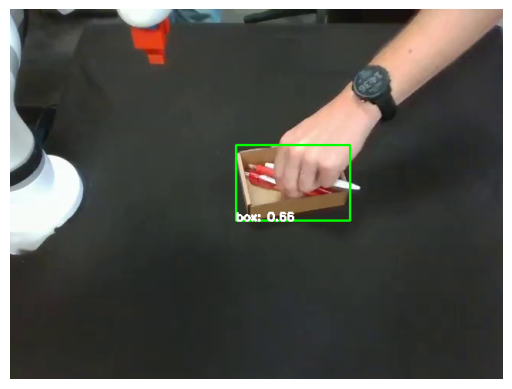

In [9]:
def visualize_boxes_on_image(img, results, text_labels):
    annotated_img = img.copy()
    # check if any annotations
    if len(results['boxes']) is None or len(results['boxes']) == 0:
        return annotated_img
    for box, label, score in zip(results['boxes'], results['labels'], results['scores']):
    
        x1, y1, x2, y2 = box
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        label_idx = text_labels.index(label)
        annotated_img = cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color_list[label_idx], 2)
        annotated_img = cv2.putText(annotated_img, f"{label}: {score:.2f}", (x1, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return annotated_img


annotated_img = visualize_boxes_on_image(img, results, text_labels)
plt.imshow(annotated_img)
plt.axis("off")
plt.show()

In [10]:
# run the model on all frames and store the results in a list 

initial_frame_results  =  []
times = []
import time 
for frame in initial_frames:
    start_time = time.time()
    # resize frame to 256x256
    # frame = cv2.resize(frame, (256, 256))
    results = get_bounding_boxes(frame, text_labels)
    end_time = time.time()
    times.append(end_time - start_time)
    initial_frame_results.append(results)


print(f"Average time per frame: {sum(times) / len(times)}")



[{'scores': tensor([0.6568], device='cuda:0'), 'boxes': tensor([[293.0114, 176.3472, 441.9817, 274.4863]], device='cuda:0'), 'text_labels': ['box'], 'labels': ['box']}]
[{'scores': tensor([0.7326, 0.4292, 0.3085], device='cuda:0'), 'boxes': tensor([[295.3576, 162.5098, 449.2026, 281.8076],
        [168.6333, 241.9855, 288.3443, 294.9731],
        [139.8315, 207.7811, 284.7319, 256.3615]], device='cuda:0'), 'text_labels': ['box', 'pen', 'pen'], 'labels': ['box', 'pen', 'pen']}]
[{'scores': tensor([0.7293, 0.5812, 0.5502], device='cuda:0'), 'boxes': tensor([[295.2268, 161.8491, 449.7122, 281.8128],
        [166.5832, 243.0200, 287.9836, 295.3078],
        [166.9752, 184.4335, 293.6638, 203.1708]], device='cuda:0'), 'text_labels': ['box', 'pen', 'pen'], 'labels': ['box', 'pen', 'pen']}]
[{'scores': tensor([0.7050, 0.5857, 0.5369], device='cuda:0'), 'boxes': tensor([[295.4788, 162.3291, 449.9132, 281.7814],
        [167.8532, 242.9858, 288.0433, 295.7671],
        [167.5702, 184.6801, 293.

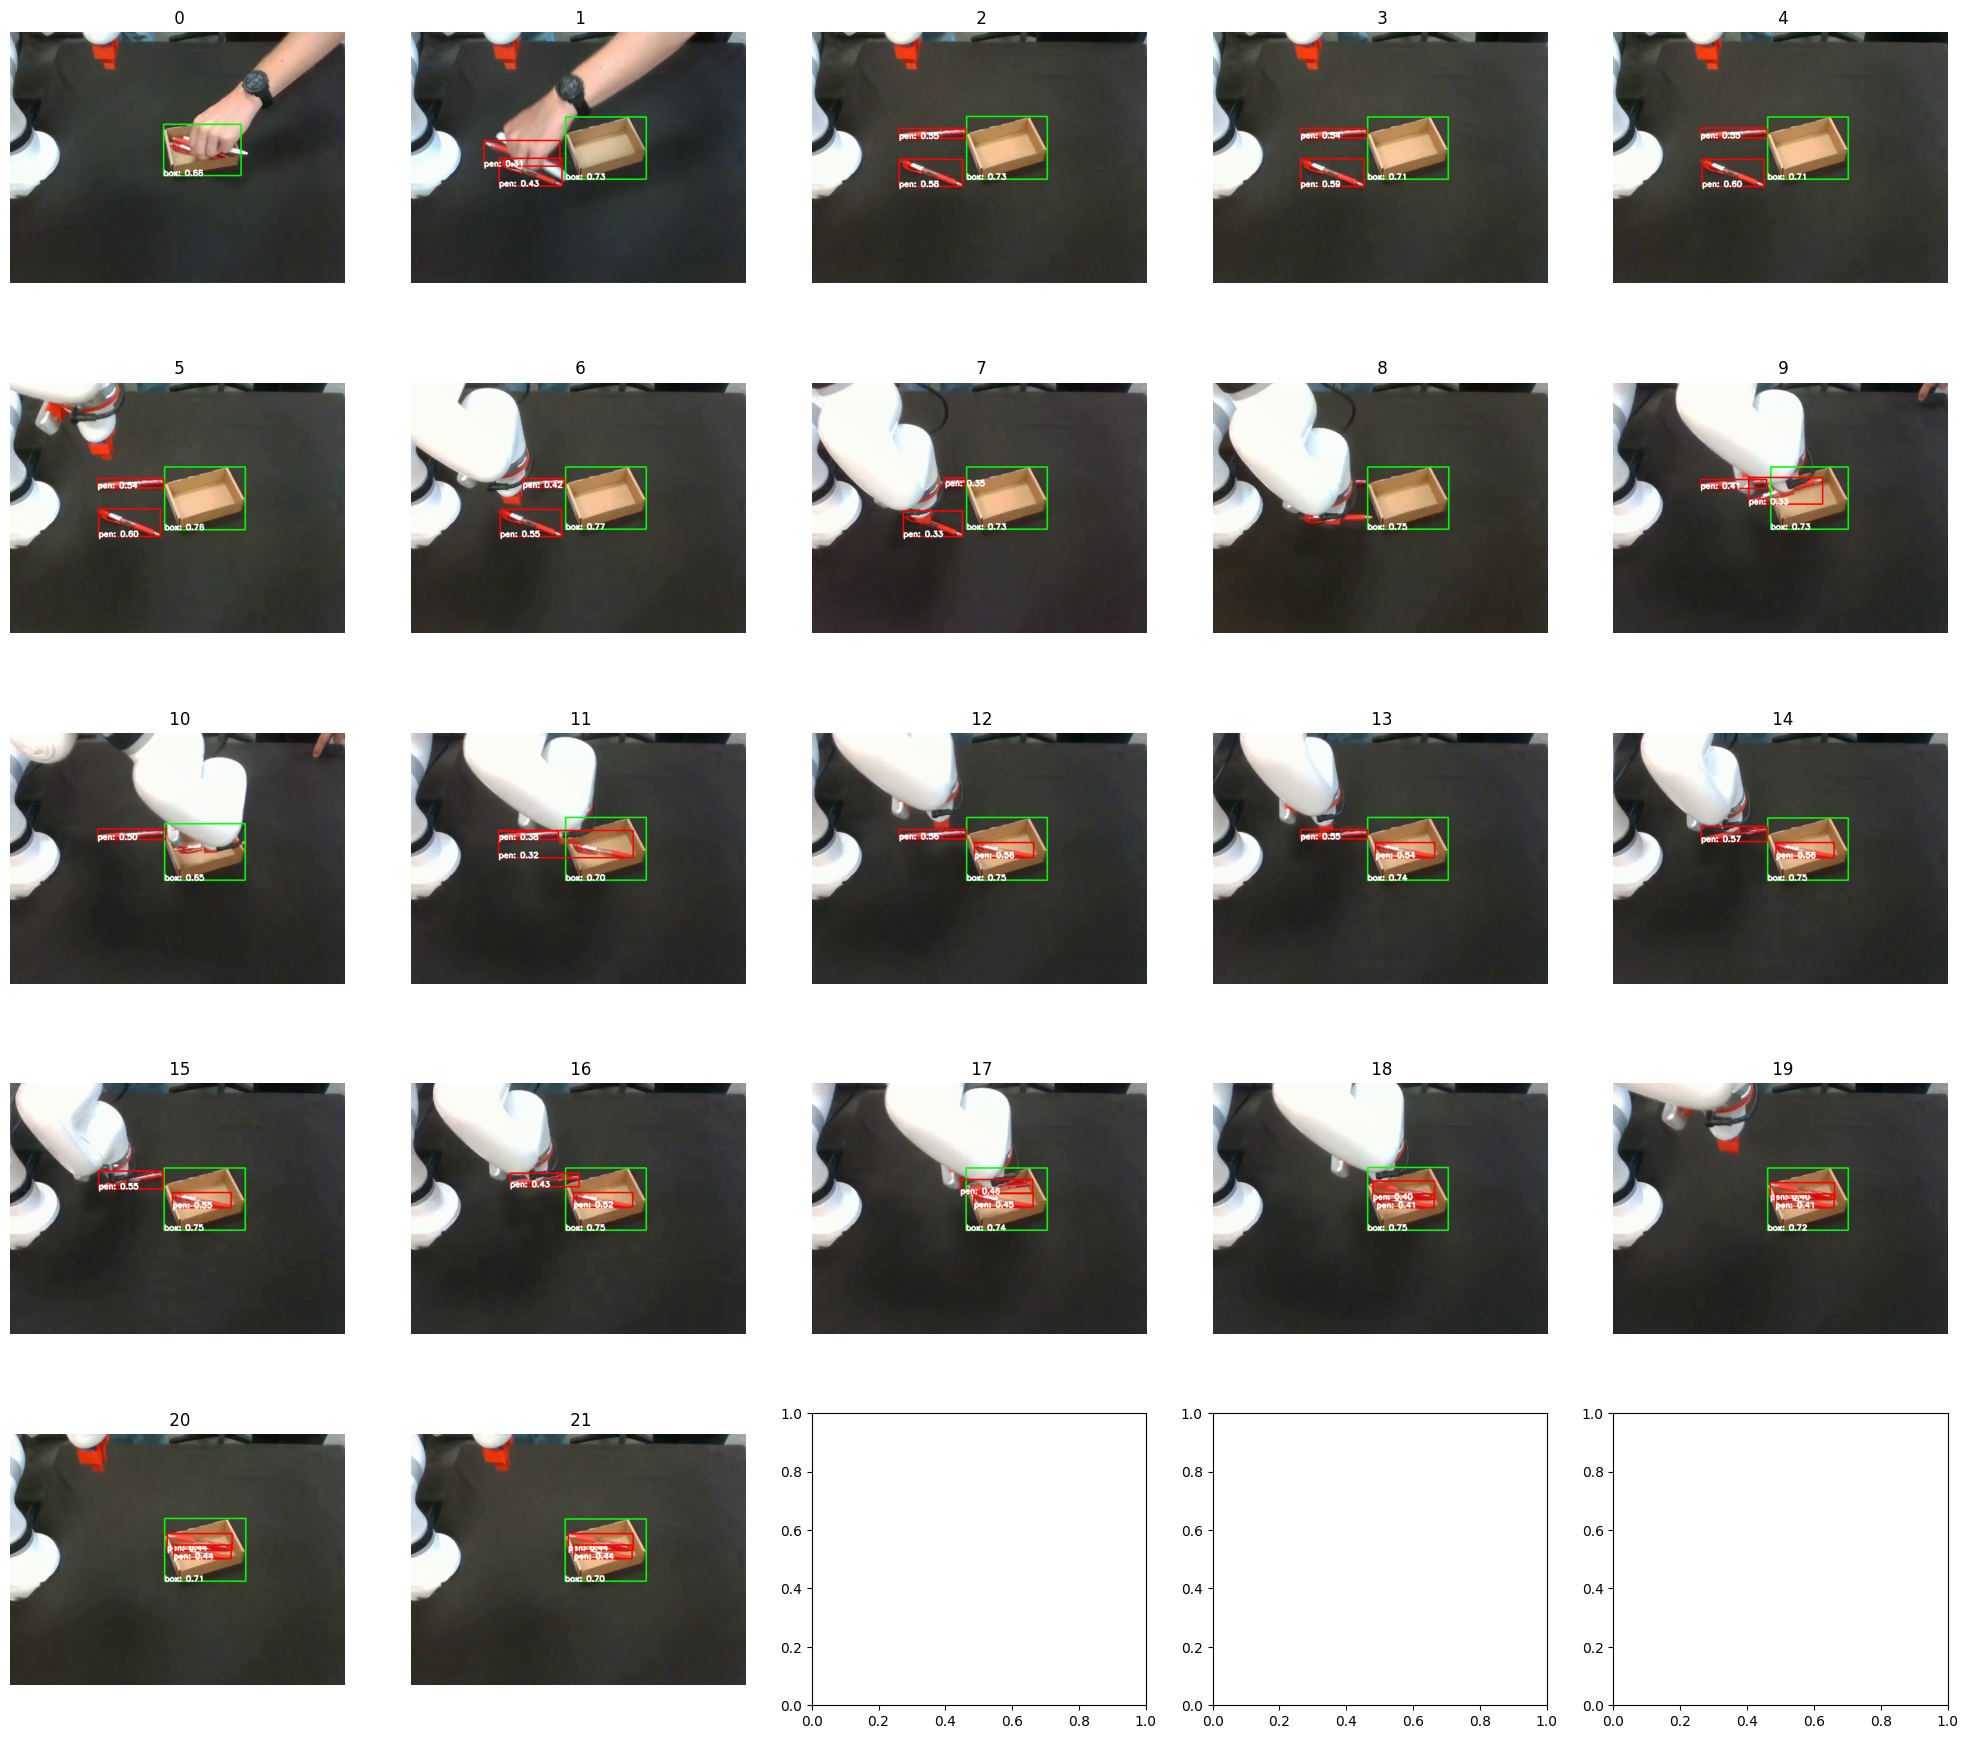

In [11]:
# visualize in a single figure with 5 by len(initial_frames) // 5 + 1 grid

fig, axs = plt.subplots(len(initial_frames) // 5 + 1, 5, figsize=(25, 5 * len(initial_frames) // 5))
for i, frame in enumerate(initial_frames):
    # frame = cv2.resize(frame, (256, 256))
    img = visualize_boxes_on_image(frame, initial_frame_results[i], text_labels)
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis("off")
    axs[i // 5, i % 5].set_title(f" {i}")
plt.show()

In [33]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 

model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

path = "../data/pen-test.png"
image = Image.open(path)
# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = [["pen","box"]]
# text = [["pen"]]

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.1,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

print(results)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

[{'scores': tensor([0.5230, 0.4227, 0.3030, 0.2743, 0.2468, 0.1845, 0.2258, 0.3046, 0.1620,
        0.1262, 0.1905, 0.2061, 0.1347, 0.2194, 0.1915, 0.1520, 0.1429, 0.1576,
        0.1448, 0.1257, 0.1144, 0.1795, 0.1126, 0.2229, 0.1096, 0.1055, 0.1234,
        0.1203], device='cuda:0'), 'boxes': tensor([[ 1.5421e+02,  1.3981e+02,  2.8405e+02,  2.1999e+02],
        [ 2.9929e+02,  2.1928e+02,  4.7596e+02,  3.4998e+02],
        [ 1.4636e+01,  2.3769e+02,  8.7593e+01,  2.5392e+02],
        [ 1.5561e-01,  2.0639e+02,  1.2660e+02,  3.0088e+02],
        [ 1.2625e-02,  2.6074e+02,  5.6742e+01,  3.4997e+02],
        [ 4.4688e+02,  2.7052e+02,  4.7596e+02,  3.1058e+02],
        [ 1.8293e+02,  2.0821e+02,  2.7124e+02,  3.1585e+02],
        [ 1.5394e-01,  2.0606e+02,  1.2668e+02,  3.4985e+02],
        [ 4.5155e+02,  3.0824e+02,  4.7600e+02,  3.4998e+02],
        [ 1.5394e+02,  1.3990e+02,  2.8442e+02,  3.4992e+02],
        [ 1.2407e+02,  1.4047e+02,  1.3652e+02,  1.8851e+02],
        [ 3.4603e+01, 

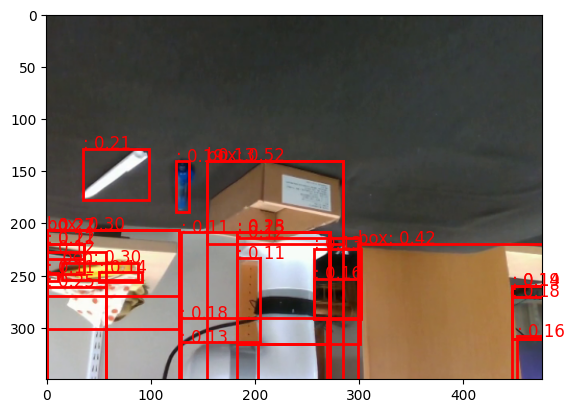

In [34]:
result = results[0]

fig, ax = plt.subplots()
ax.imshow(image)
for box, label, score in zip(result['boxes'], result['labels'], result['scores']):
    x1, y1, x2, y2 = box.cpu().numpy()
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
    ax.text(x1, y1, f"{label}: {score:.2f}", color='red', fontsize=12)
plt.show()
